In [1]:
using GoldGates
using MSSim: Optimizers as Opts, SegSeq as SS, SymLinear as SL, Sequence as Seq, Utils as U

In [2]:
using BenchmarkTools
using NLopt
using Statistics
using PyPlot
using JSON
ENV["MPLBACKEND"] = "module://matplotlib_inline.backend_inline"

"module://matplotlib_inline.backend_inline"

In [3]:
sysparams = open("../system params/072125_goldparams_13ions.json") do io
    read(io, GoldGates.SystemParams; format=:json)
end;

In [4]:
# Construct modes matrtix using system parameters
const modes = Seq.Modes()
const nions = 13
const ion1 = 5
const ion2 = 9
for i in 1:13
    push!(modes, 2π * sysparams.modes.radial1[i], sysparams.participation_factors[i][ion1] * sysparams.participation_factors[i][ion2] * sysparams.lamb_dicke_parameters[i]^2)
end

In [5]:
const blackman_start_end = U.BlackmanStartEnd{0.7}()

(::MSSim.Utils.BlackmanStartEnd{0.7}) (generic function with 1 method)

In [6]:
const nseg = 120
const buf_opt = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_allδ), Val(SS.mask_allδ));
const buf_plot = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_full), Val(SS.mask_full));

In [7]:
function _objfunc(vals)
    dis = vals[1]
    disδ = vals[2]
    area = vals[3]
    areaδ = vals[4]
    τ = vals[5]

    return 5 * dis + disδ / 100 + (abs(area) - π / 2)^2 * 100 + (areaδ / 1e4)^2
end
const objfunc = Opts.autodiff(_objfunc);

In [8]:
const nlmodel = Seq.Objective(SL.pmask_full,
                              ((:dis2, 0), (:disδ2, 0), (:area, 0),
                               (:areaδ, 0), (:τ, 0)),
                              objfunc, modes, buf_opt,
                              freq=Seq.FreqSpec(true, sym=false),
                              amp=Seq.AmpSpec(cb=blackman_start_end));

In [9]:
pitime_to_Ω(time) = π / (2 * time)
const nargs = Seq.nparams(nlmodel)
const tracker = Opts.NLVarTracker(nargs)
Opts.set_bound!(tracker, nlmodel.param.τ, 0.1, 2.5)
Opts.set_bound!(tracker, nlmodel.param.Ωs[1], pitime_to_Ω(8), pitime_to_Ω(3.8))
for ω in nlmodel.param.ωs
    Opts.set_bound!(tracker, ω, 2π * 2.29, 2π * 2.50)
end

In [10]:
# const opt = NLopt.Opt(:LD_SLSQP, nargs)
const opt = NLopt.Opt(:LD_LBFGS, nargs)
# NLopt.xtol_rel!(opt, 1e-5)
# NLopt.ftol_rel!(opt, 1e-5)
NLopt.min_objective!(opt, nlmodel)
NLopt.lower_bounds!(opt, Opts.lower_bounds(tracker))
NLopt.upper_bounds!(opt, Opts.upper_bounds(tracker))
NLopt.maxtime!(opt, 10)

In [11]:
best_obj = 100.0
best_params = nothing
@time for i in 1:100
    global best_obj, best_params
    obj, params, ret = @time NLopt.optimize(opt, Opts.init_vars!(tracker))
    if getfield(NLopt, ret) < 0
        continue
    end
    if obj < best_obj
        best_obj = obj
        area = nlmodel(Val((:area, 0)), params)
        best_status = (
            obj = obj,
            dis = nlmodel(Val((:dis2, 0)), params),
            disδ = nlmodel(Val((:disδ2, 0)), params),
            area = area,
            areaε = abs(area) - π / 2,
            areaδ = nlmodel(Val((:areaδ, 0)), params),
            total_t = nlmodel(Val((:τ, 0)), params),
            Ωmax = params[nlmodel.param.Ωs[1]],
        )
        println(best_status)
        best_params = params
    end
end

  0.439029 seconds (1.22 M allocations: 61.526 MiB, 2.42% gc time, 92.75% compilation time)
  0.282048 seconds (2.55 k allocations: 636.141 KiB)
  1.305839 seconds (12.11 k allocations: 2.955 MiB)
  0.362550 seconds (3.02 k allocations: 753.062 KiB)
  0.015293 seconds (180 allocations: 43.562 KiB)
  0.834431 seconds (7.76 k allocations: 1.893 MiB)
  0.015006 seconds (177 allocations: 42.812 KiB)
  0.014395 seconds (169 allocations: 40.812 KiB)
  0.748115 seconds (6.91 k allocations: 1.685 MiB)
  0.018667 seconds (215 allocations: 52.312 KiB)
  2.607702 seconds (25.90 k allocations: 6.323 MiB)
  0.432590 seconds (3.44 k allocations: 857.562 KiB)
  0.015670 seconds (184 allocations: 44.562 KiB)
  0.596777 seconds (5.21 k allocations: 1.271 MiB)
  0.014857 seconds (175 allocations: 42.312 KiB)
  0.016017 seconds (188 allocations: 45.562 KiB)
  1.525407 seconds (14.22 k allocations: 3.471 MiB, 0.32% gc time)
(obj = 58.80271557211003, dis = 3.2900440064200533, disδ = 48.63020879001159, area

In [12]:
opt_raw_params = Seq.RawParams(nlmodel, best_params)
println(opt_raw_params)

MSSim.Sequence.RawParams([2.100301107643343, -5.720918479153852e-18, 0.0005439813789852465, 0.0, 15.096941851888245, 2.100301107643343, 0.0011425246928200609, 0.0017008585654575653, 31.708123693548025, 15.045281338748712, 2.100301107643343, 0.004714839821795253, 0.003052079417284323, 63.30774475412766, 14.673760205406456, 2.100301107643343, 0.011125125602532966, 0.004687494085372264, 94.12705956683565, 15.170073700581662, 2.100301107643343, 0.020970274622111953, 0.006642854350025867, 125.98878216319847, 15.060533898969819, 2.100301107643343, 0.03492226897138468, 0.00888842163108009, 157.62043819290488, 14.972069049070537, 2.100301107643343, 0.05359063076834324, 0.011326291450995582, 189.06629140038035, 14.795645048859802, 2.100301107643343, 0.07737925324836059, 0.013796947341481151, 220.14160108479834, 15.159582890061987, 2.100301107643343, 0.10635699703177033, 0.016094413360778107, 251.9812898202066, 15.184767550098403, 2.100301107643343, 0.1401601112402824, 0.017988301801708195, 283.

In [13]:
kern = SL.Kernel(buf_plot, Val(SL.pmask_full));

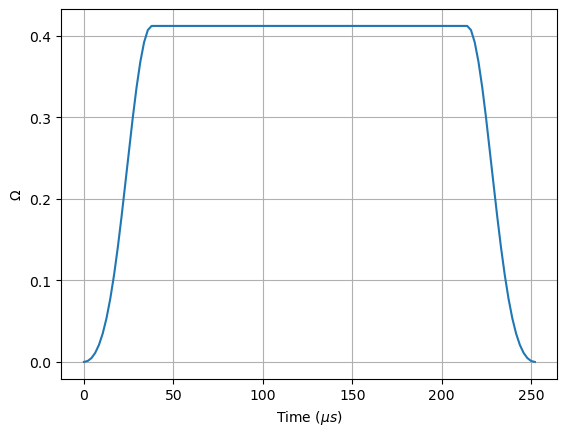

In [14]:
clf()
plot(Seq.get_Ωs(opt_raw_params)...)
xlabel(raw"Time ($\mu s$)")
ylabel(raw"$\Omega$")
grid()
# display(gcf())

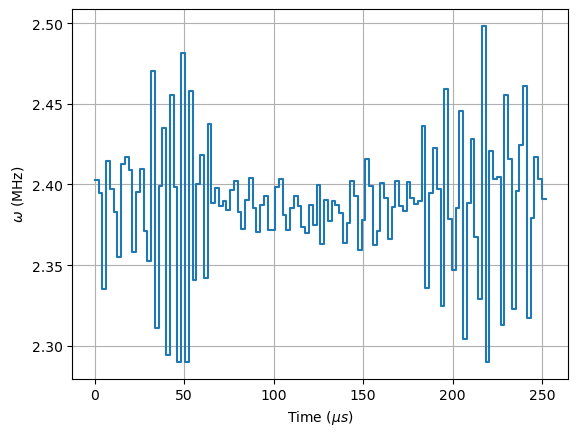

In [15]:
clf()
ts, ωs = Seq.get_ωs(opt_raw_params)
plot(ts, ωs ./ 2π)
xlabel(raw"Time ($\mu s$)")
ylabel(raw"$\omega$ (MHz)")
grid()
# display(gcf())

In [16]:
println("Total displacement:")
println(Seq.total_dis(kern, opt_raw_params, modes))
println("cumulative displacement:")
println(Seq.total_cumdis(kern, opt_raw_params, modes))
println("Gradient of displacement w.r.t. detuning (disδ)")
println(Seq.total_disδ(kern, opt_raw_params, modes))
enclosed_area = Seq.total_area(kern, opt_raw_params, modes)
println("Enclosed area (area)")
println(enclosed_area)
println("Gradient of enclosed area w.r.t. detuning (areaδ)")
println(Seq.total_areaδ(kern, opt_raw_params, modes))

Total displacement:
2.5416502955504487e-10
cumulative displacement:
1.659931501760965e-5
Gradient of displacement w.r.t. detuning (disδ)
3.252565818285509e-9
Enclosed area (area)
1.5707961197516846
Gradient of enclosed area w.r.t. detuning (areaδ)
-56.932804444119796


In [17]:
plot_δs = range(-1, 1, 10001); # kHz

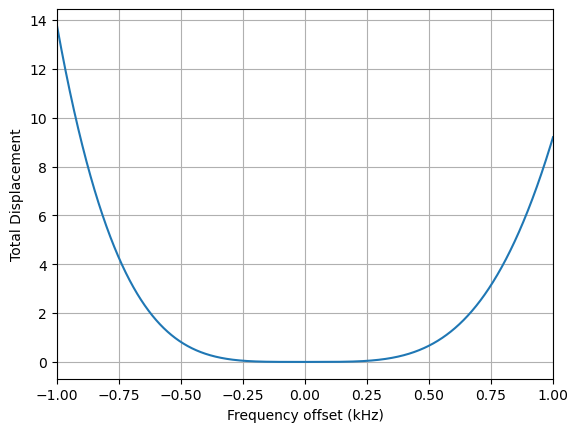

In [18]:
clf()
plot(plot_δs, [Seq.total_dis(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) for δ in plot_δs])
xlim([-1, 1])
# ylim([0, 100])
xlabel("Frequency offset (kHz)")
ylabel("Total Displacement")
grid()
# display(gcf())

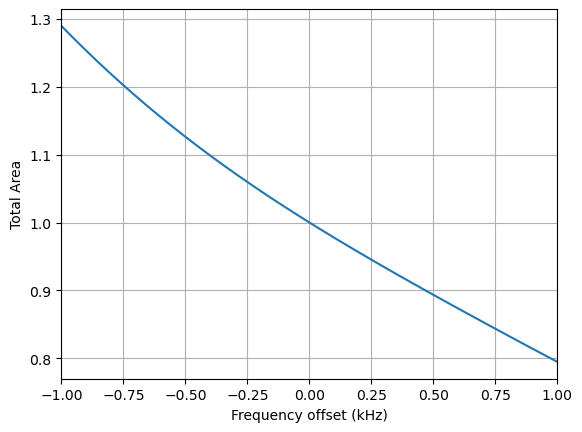

In [19]:
clf()
area0 = Seq.total_area(kern, opt_raw_params, modes)
plot(plot_δs, [Seq.total_area(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) / area0 for δ in plot_δs])
xlim([-1, 1])
xlabel("Frequency offset (kHz)")
ylabel("Total Area")
grid()
# display(gcf())

In [20]:
_ion1 = ion1 - (nions + 1) ÷ 2
_ion2 = ion2 - (nions + 1) ÷ 2
solution_set = GoldGates.GateSolutionSet(params=sysparams, XX=Dict("$_ion1:$_ion2"=>GoldGates.XXSolution(opt_raw_params, enclosed_area)))
open("../out/20250722_linear_pm_13_v2.json", "w") do io
    write(io, solution_set, format=:json)
end